# **About Dataset**
The dataset contains complete loan data for all loans issued through the year
2007 - 2015, including the current loan status (Current, Late, Fully Paid, etc.)
and latest payment information. Our dataset contains total of 8,55,969 records
with 73 features including target variable. Moreover, the dataset is very
unbalanced, with approximately 6 % of loans considered as defaulted. This
dataset has different types of features such as categorical, numeric & date.

# Some important features:

**loanamnt** -  Amount of money requested by the borrower. • intrate - Interest rate of the loan.

**grade** Loan - grade with categories A, B, C, D, E, F, G.

**annual_inc** - Borrowers annual income.

**purpose** - The primary purpose of borrowing.

**installments** - Monthly amount payments for opted loan.

**term** - duration of the loan until it’s paid off

# **Note**
A default can occur when a borrower is unable to make timely payments, misses
payments, avoids or stops making payments.


**TARGET**

default_ind


# 1. Read Spark DF using pd API

In [ ]:
#install pyspark
!pip install pyspark
#install sklearn
!pip install sklearn
#install Tensflow
!pip install tensorflow
#install tensorflow_decision_forests
!pip install tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 49 kB/s 
     |████████████████████████████████| 199 kB 55.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=c82c3ddcd24f455597f70aa94e1f2d1581b0866dbd4fc76375329f6129ee4413
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=af5634f19236b0960ef4e00f575e77b0079ac8626b7059814b09d66626bf22a4
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Lookin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import io
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

In [ ]:
import pyspark
from pyspark.sql import SparkSession
#spark = SparkSession.builder.getOrCreate()
#spark = SparkSession.builder.master("local").appName("Colab").config("spark.ui.port", '4050').getOrCreate()
spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "15g") \
    .appName('my-cool-app') \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
spark.version

'3.3.0'

### Convert pandas dataframe to pandas-on-spark dataframe

In [ ]:
import pyspark.pandas as ps
psdf = pyspark.pandas.read_csv('./drive/MyDrive/data.csv')
#psdf = pyspark.pandas.read_csv('data.csv')

/usr/local/lib/python3.7/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [ ]:
psdf.shape

(855969, 73)

In [ ]:
psdf.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 855969 entries, 0 to 855968
Data columns (total 73 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           855969 non-null  int32  
 1   member_id                    855969 non-null  int32  
 2   loan_amnt                    855969 non-null  int32  
 3   funded_amnt                  855969 non-null  int32  
 4   funded_amnt_inv              855969 non-null  float64
 5   term                         855969 non-null  object 
 6   int_rate                     855969 non-null  float64
 7   installment                  855969 non-null  float64
 8   grade                        855969 non-null  object 
 9   sub_grade                    855969 non-null  object 
 10  emp_title                    806530 non-null  object 
 11  emp_length                   855969 non-null  object 
 12  home_ownership               855969 non-null  object 
 

**Conclusion**

1.Dataset does not ahve correct data type need to change to relevant datatype

> term - remove months change to int

> emp_length - check how can we improve this column

> annual_inc - chenge to float

> issue_d - change to date format

>dti change to float

>delinq_2yrs check if could be converted to int

>earliest_cr_line change to date format

>inq_last_6mths change to int

>mths_since_last_delinq change to int

>mths_since_last_record chage to int

>open_acc change to int

>pub_rec change to int

>revol_bal change to int

>revol_util change to float

>total_acc change to int

>out_prncp and out_prncp_inv change to float

>total_pymnt and total_pymnt_inv change to float

>total_rec_prncp and total_rec_int and total_rec_late_fee change to float

>recoveries change to float

> collection_recovery_fee change to float

>last_pymnt_d change to date format

>last_pymnt_amnt change to float

>next_pymnt_d change to date format

>last_credit_pull_d change to date format

>collections_12_mths_ex_med change to int

>mths_since_last_major_derog change to int

>policy_code change to int

>acc_now_delinq change to int or float

>tot_coll_amt change to float

>tot_cur_bal change to float

>total_rev_hi_lim change to float

# 2. Cleaning & preprocessing


In [ ]:
#let's check dublicates
psdf.duplicated().sum()

0

In [ ]:
#Drop empty columns and columns that are less than 5%
#Function checks % of missing values in a column. Those Columns that are less than 5% will be removed from DF
def check_percentage_ofMissingValues(data):
      columns_to_consider_with_less15 = []
      columns_to_consider_with_more15 = []
      #we include id, and member_id as we do not need them and date formats as well, as many of them are missing in default index == 1
      dropColumns = ['id','member_id','next_pymnt_d','last_credit_pull_d','earliest_cr_line','issue_d','last_pymnt_d']
      for x in data.columns:
        percentage = (100 - (data[x].isna().sum()/len(data)*100))
        if percentage < 5:
            dropColumns.append(x)
        elif percentage < 15:
          columns_to_consider_with_less15.append(x)
        elif percentage < 99.99:
          columns_to_consider_with_more15.append(x)

      print(f'columns to be dropped:{dropColumns}')
      print(f'columns percentage to be considered less then 15%:{columns_to_consider_with_less15}')
      print(f'columns percentage to be considered more then 15%:{columns_to_consider_with_more15}')
      return dropColumns,columns_to_consider_with_less15,columns_to_consider_with_more15

def preprocessing_ds(data):
    preprocessing = data.copy()

    #Convert to int
    convert_to_int = ['delinq_2yrs','inq_last_6mths',
                  'mths_since_last_delinq','mths_since_last_record',
                  'open_acc','pub_rec','total_acc',
                 'collections_12_mths_ex_med','mths_since_last_major_derog',
                 'policy_code','acc_now_delinq']
    #convert to float
    convert_to_float = ['revol_bal','revol_util','dti',
                    'annual_inc','out_prncp','out_prncp_inv',
                   'total_pymnt','total_rec_prncp','total_rec_int',
                   'total_rec_late_fee','recoveries','collection_recovery_fee',
                   'last_pymnt_amnt','tot_coll_amt','tot_cur_bal','total_rev_hi_lim']
    #delinq_2yrs drop that == 'Ring'

    preprocessing = preprocessing[preprocessing["delinq_2yrs"].str.contains("Ring") == False]

    #drop this rows as it is miss placed
    preprocessing = preprocessing[preprocessing['purpose'].str.contains("Nevada") == False]
    preprocessing = preprocessing[preprocessing['purpose'].str.contains("550") == False]
    preprocessing = preprocessing[preprocessing['purpose'].str.contains("married") == False]

    preprocessing[convert_to_int] = preprocessing[convert_to_int].astype('Int64')
    preprocessing[convert_to_float] = preprocessing[convert_to_float].astype('Float64')
    #desciption looks very different from each other nad it has date it is better to replace those values
    #it can not be filled with any others, better solution is to drop column and as well as it says it is not important feature
    preprocessing = preprocessing.drop(['desc'], axis=1)
    #fill null values with 'others'
    preprocessing['emp_title'] = preprocessing['emp_title'].fillna('others')
    #title fill na with Debt consolidation
    preprocessing['title'] = preprocessing['title'].fillna('Debt consolidation')

    #fill null values with median
    preprocessing['mths_since_last_delinq'] = preprocessing['mths_since_last_delinq'].fillna(preprocessing['mths_since_last_delinq'].median())
    preprocessing['mths_since_last_record'] = preprocessing['mths_since_last_record'].fillna(preprocessing['mths_since_last_record'].median())


    #mths_since_last_major_derog
    preprocessing = preprocessing[(preprocessing['mths_since_last_major_derog']>=0) | preprocessing['mths_since_last_major_derog'].isnull()]
    preprocessing['mths_since_last_major_derog'] = preprocessing['mths_since_last_major_derog'].astype('Int64')
    preprocessing['mths_since_last_major_derog'] = preprocessing['mths_since_last_major_derog'].fillna(preprocessing['mths_since_last_major_derog'].median())

    #tot_coll_amt
    preprocessing = preprocessing[(preprocessing['tot_coll_amt']>=0) | preprocessing['tot_coll_amt'].isnull()]
    preprocessing['tot_coll_amt'] = preprocessing['tot_coll_amt'].astype('Int64')
    preprocessing['tot_coll_amt'] = preprocessing['tot_coll_amt'].fillna(preprocessing['tot_coll_amt'].median())

    #tot_cur_bal
    preprocessing = preprocessing[(preprocessing['tot_cur_bal']>=0) | preprocessing['tot_cur_bal'].isnull()]
    preprocessing['tot_cur_bal'] = preprocessing['tot_cur_bal'].astype('Int64')
    preprocessing['tot_cur_bal'] = preprocessing['tot_cur_bal'].fillna(preprocessing['tot_cur_bal'].median())

    #total_rev_hi_lim
    preprocessing = preprocessing[(preprocessing['total_rev_hi_lim']>=0) | preprocessing['total_rev_hi_lim'].isnull()]
    preprocessing['total_rev_hi_lim'] = preprocessing['total_rev_hi_lim'].astype('Int64')
    preprocessing['total_rev_hi_lim'] = preprocessing['total_rev_hi_lim'].fillna(preprocessing['total_rev_hi_lim'].median())

    #revol_util
    preprocessing['revol_util'] = preprocessing['revol_util'].fillna(preprocessing['revol_util'].median())

    #default_ind remove null values
    preprocessing= preprocessing[preprocessing['default_ind'].notnull()]

    #collections_12_mths_ex_med
    preprocessing['collections_12_mths_ex_med'] = preprocessing['collections_12_mths_ex_med'].fillna(preprocessing['collections_12_mths_ex_med'].median())

    #term convert to int remove months
    preprocessing['term'] = preprocessing['term'].str.replace('\D+', '')
    preprocessing['term'] = preprocessing['term'].astype('Int64')

    #emp_length convert to int remove years/year
    preprocessing['emp_length'] = preprocessing['emp_length'].str.replace('\D+', '')
    preprocessing['emp_length'] = preprocessing['emp_length'].astype('Int64')

    # #covnert to date issue_d & earliest_cr_line


    #total_pymnt_inv convert to float
    preprocessing['total_pymnt_inv'] = preprocessing['total_pymnt_inv'].astype('Float64')
    psdf['emp_length'] = psdf['emp_length'].fillna(1)
    return preprocessing

In [ ]:
columns_to_drop,columns_less15,cololumns_more15 = check_percentage_ofMissingValues(psdf)

#drop columns
psdf = psdf.drop(columns_to_drop, axis=1)
#preprocessing data
psdf = preprocessing_ds(psdf)

columns to be dropped:['id', 'member_id', 'next_pymnt_d', 'last_credit_pull_d', 'earliest_cr_line', 'issue_d', 'last_pymnt_d', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']
columns percentage to be considered less then 15%:['desc']
columns percentage to be considered more then 15%:['emp_title', 'mths_since_last_delinq', 'mths_since_last_record', 'revol_util', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'default_ind']


**Conclusion**
> found 0 dublicates

> Columns dropped as they have less than 5% values in DF

'id', 'member_id', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m'

>Column Dropped 'desc' has 15% values in DF

Could not be filled with any other values, as this column is unique an represents each values as date with comment

>columns filled with median

'mths_since_last_delinq','mths_since_last_record','mths_since_last_major_derog','tot_coll_amt','tot_cur_bal'
'total_rev_hi_lim'

>Found 0 dublicates after preprocessing


# Box Plot OR histograms to find Noise or Outliers

In [ ]:
testing =psdf.copy()
data_num = testing.select_dtypes(exclude=['object']).columns.tolist()
data_num.remove('term')
data_num.remove('loan_amnt')
data_num.remove('funded_amnt')
data_num.remove('funded_amnt_inv')
data_num.remove('emp_length')

print(f'display this columns {data_num}')

display this columns ['int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'default_ind']


In [ ]:
testing['default_ind'].plot('hist')

**target**-default_ind is very imbalanced. Required to upsampling or find another method to improve model

In [ ]:
testing['annual_inc'].plot.box()

In [ ]:
testing['int_rate'].plot.box()

can be seen outliers in int_rate .... ???

In [ ]:
testing['dti'].plot.box()

can be seen outliers in dti .... ???

In [ ]:
testing['installment'].plot.box()

In [ ]:
testing['delinq_2yrs'].plot.box()

In [ ]:
testing['inq_last_6mths'].plot.box()

In [ ]:
testing['mths_since_last_delinq'].plot.box()

In [ ]:
testing['open_acc'].plot.box()

In [ ]:
testing['pub_rec'].plot.box()

In [ ]:
testing['revol_bal'].plot.box()

In [ ]:
testing['revol_util'].plot.box()

In [ ]:
testing['total_acc'].plot.box()

In [ ]:
testing['out_prncp'].plot.box()

In [ ]:
testing['out_prncp_inv'].plot.box()

In [ ]:
testing['total_pymnt'].plot.box()

In [ ]:
testing['total_pymnt_inv'].plot.box()

In [ ]:
testing['total_rec_prncp'].plot.box()

In [ ]:
testing['total_rec_int'].plot.box()

In [ ]:
testing['total_rec_late_fee'].plot.box()

In [ ]:
testing['recoveries'].plot.box()

In [ ]:
testing['collection_recovery_fee'].plot.box()

In [ ]:
testing['collections_12_mths_ex_med'].plot.box()

In [ ]:
testing['mths_since_last_major_derog'].plot.box()

In [ ]:
testing['policy_code'].plot.box()

In [ ]:
testing['acc_now_delinq'].plot.box()

In [ ]:
testing['tot_coll_amt'].plot.box()

In [ ]:
testing['tot_cur_bal'].plot.box()

In [ ]:
testing['total_rev_hi_lim'].plot.box()

# 4. Correlation


In [ ]:
data_num = testing.select_dtypes(exclude=['object']).columns.tolist()

In [ ]:
corr = testing[data_num].corr()

In [ ]:
corr.style.background_gradient(cmap='coolwarm')

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,mths_since_last_delinq,mths_since_last_record,revol_util,collections_12_mths_ex_med,mths_since_last_major_derog,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,default_ind
loan_amnt,1.000000,0.999269,0.997624,0.142916,0.944872,-0.028688,-0.006614,0.119546,-0.017045,-0.002860,-0.003542,0.324620,0.305268,-0.004887
funded_amnt,0.999269,1.000000,0.998504,0.143071,0.945900,-0.028680,-0.006704,0.120062,-0.016891,-0.002860,-0.003512,0.325411,0.305809,-0.005779
funded_amnt_inv,0.997624,0.998504,1.000000,0.143326,0.944173,-0.027790,-0.002558,0.120824,-0.016560,-0.002866,-0.003444,0.326180,0.306148,-0.008151
int_rate,0.142916,0.143071,0.143326,1.000000,0.130423,-0.012387,0.009051,0.271554,0.012840,-0.001785,0.001367,-0.082775,-0.156520,0.155057
installment,0.944872,0.945900,0.944173,0.130423,1.000000,-0.029808,-0.008813,0.131846,-0.014566,-0.002909,-0.002852,0.294683,0.280690,0.004753
mths_since_last_delinq,-0.028688,-0.028680,-0.027790,-0.012387,-0.029808,1.000000,-0.022613,0.006119,-0.025114,0.057928,0.007364,-0.061144,-0.028406,-0.000976
mths_since_last_record,-0.006614,-0.006704,-0.002558,0.009051,-0.008813,-0.022613,1.000000,0.032474,-0.009906,-0.001931,-0.006200,-0.009979,-0.008160,0.021729
revol_util,0.119546,0.120062,0.120824,0.271554,0.131846,0.006119,0.032474,1.000000,-0.035713,-0.000811,-0.008543,0.079561,-0.108963,0.044445
collections_12_mths_ex_med,-0.017045,-0.016891,-0.016560,0.012840,-0.014566,-0.025114,-0.009906,-0.035713,1.000000,-0.009842,0.009868,-0.007256,-0.014843,-0.010644
mths_since_last_major_derog,-0.002860,-0.002860,-0.002866,-0.001785,-0.002909,0.057928,-0.001931,-0.000811,-0.009842,1.000000,0.001731,-0.005244,-0.001134,-0.001025


In [ ]:
corr['default_ind'].sort_values(ascending=False)

default_ind                    1.000000
int_rate                       0.155057
revol_util                     0.044445
mths_since_last_record         0.021729
installment                    0.004753
mths_since_last_delinq        -0.000976
mths_since_last_major_derog   -0.001025
tot_coll_amt                  -0.002444
loan_amnt                     -0.004887
funded_amnt                   -0.005779
funded_amnt_inv               -0.008151
collections_12_mths_ex_med    -0.010644
total_rev_hi_lim              -0.037421
tot_cur_bal                   -0.045125
Name: default_ind, dtype: float64

**Conclusion**

it can be seen that correlation with default_ind is very small to all columns
but the highest correlated column is interest rate to default_ind

Interesting fact that Installment highly correlated with Loan amount, funded amount and funded amount inv


# 5. Visualise & Analyse

**in this topic we are going to analyse how several columns relates to default index**

In [ ]:
visualization_dataset = testing.copy()

In [ ]:
#Let's check how likly grade depends  on borrower is unable to make timely payments, misses payments, avoids or stops making payments.
visualization_grade=visualization_dataset.groupby('grade').agg({'default_ind':['count','sum']})
visualization_grade['percentage_category'] = (visualization_grade['default_ind']['sum']  / visualization_grade['default_ind'] ['count'])*100
display(visualization_grade)

default_ind        percentage_category
            count    sum                    
grade                                       
F           21323   3012           14.125592
E           66434   6455            9.716410
B          247916   9709            3.916246
D          132771  10789            8.126021
C          236808  12993            5.486723
A          145620   2663            1.828732
G            4871    813           16.690618

Those who take loan with grade B and A most likely pays it on time
However those people who take loan with grade F or G less likely pays it on time and misses payments or avoid or srop making payments. Then it goes small_businesses and wedding


thus it has correlation between purpose and payment on time

In [ ]:
#Let's check how likly purpose depends on borrower is unable to make timely payments, misses payments, avoids or stops making payments.
visualization_purpose=visualization_dataset.groupby('purpose').agg({'default_ind':['count','sum']})
visualization_purpose['percentage_category'] = (visualization_purpose['default_ind']['sum']  / visualization_purpose['default_ind'] ['count'])*100
display(visualization_purpose)

default_ind        percentage_category
                         count    sum                    
purpose                                                  
wedding                   2277    265           11.638120
educational                316     54           17.088608
other                    40926   2998            7.325417
small_business            9757   1379           14.133443
debt_consolidation      505316  28381            5.616486
credit_card             200105   8054            4.024887
moving                    5159    436            8.451250
vacation                  4542    278            6.120652
renewable_energy           549     54            9.836066
house                     3508    293            8.352338
car                       8589    458            5.332402
major_purchase           16571    887            5.352725
medical                   8188    582            7.107963
home_improvement         49940   2315            4.635563

Those who take loan on credit_card most likely pays it on time same as home improvement and debt_consolidation
However those people who take loan on educational less likely pays it on time and misses payments or avoid or srop making payments. Then it goes small_businesses and wedding


thus it has correlation between purpose and payment on time

In [ ]:
#application_type
#Let's check how likly application_type depends on borrower is unable to make timely payments, misses payments, avoids or stops making payments.
visualization_app_type = visualization_dataset.groupby('application_type').agg({'default_ind':['count','sum']})
visualization_app_type['percentage_category'] = (visualization_app_type['default_ind']['sum']  / visualization_app_type['default_ind'] ['count'])*100
display(visualization_app_type)

default_ind        percentage_category
                       count    sum                    
application_type                                       
INDIVIDUAL            855301  46434            5.428966
JOINT                    442      0            0.000000

Those who take loan with two co-borrowers  pays it on time same as home improvement and debt_consolidation
However those people who take loan individually less likely pays it on time and misses payments or avoid or srop making payments

In [ ]:
#home_ownership
#Let's check how likly home_ownership depends on borrower is unable to make timely payments, misses payments, avoids or stops making payments.
visualization_home_ownership=visualization_dataset.groupby('home_ownership').agg({'default_ind':['count','sum']})
visualization_home_ownership['percentage_category'] = (visualization_home_ownership['default_ind']['sum']  / visualization_home_ownership['default_ind'] ['count'])*100
display(visualization_home_ownership)

default_ind        percentage_category
                     count    sum                    
home_ownership                                       
OWN                  84117   4131            4.911017
RENT                342417  21904            6.396879
MORTGAGE            429017  20365            4.746898
ANY                      3      0            0.000000
OTHER                  144     27           18.750000
NONE                    45      7           15.555556

Those who take loan with and home_ownership "MORTGAGE" pays it on time same as home improvement and debt_consolidation
However those people who take loan and home_ownership "Any" or "other"  less likely pays it on time and misses payments or avoid or srop making payments

# 7. Report

The data cleaning and analysis was done by using Pandas on spark data frame. At first, we checked the data and found that most of the data was in object datatype that needs to be changed to the correct datatype. Here is a list of incorrect data along with their required correct data types:
> •	term - remove months change to int

> •	emp_length: check how can we improve this column

> •	annual_inc: change to float

> •	issue_d: change to date format

> •	dti: change to float

> •	delinq_2yrs: check if could be converted to int

> •	earliest_cr_line: change to date format

> •	inq_last_6mths: change to int

> •	mths_since_last_delinq: change to int

> •	mths_since_last_record: change to int

> •	open_acc: change to int

> •	pub_rec: change to int

> •	revol_bal: change to int

> •	revol_util: change to float

> •	total_acc: change to int

> •	out_prncp and out_prncp_inv: change to float

> •	total_pymnt and total_pymnt_inv: change to float

> •	total_rec_prncp and total_rec_int and total_rec_late_fee: change to float
> •	recoveries: change to float

> •	collection_recovery_fee: change to float

> •	last_pymnt_d: change to date format

> •	last_pymnt_amnt: change to float

> •	next_pymnt_d: change to date format

> •	last_credit_pull_d: change to date format

> •	collections_12_mths_ex_med: change to int

> •	mths_since_last_major_derog: change to int

> •	policy_code: change to int

> •	acc_now_delinq: change to int or float

> •	tot_coll_amt: change to float

> •	tot_cur_bal: change to float

> •	total_rev_hi_lim: change to float


Then, we checked if there is any duplicate data present. The data is unique with no duplications found. The columns in the data frame which contained less than 5 percent of data were removed get high level of accuracy and the function to pre-process data was created from scratch.
> •	Function check_percentage_ofMissingValues() checks all the colmns which contain data with less than 5 percent, less than 15 percent and greater than 15 percent.

> •	Function preprocess_ds() converts the data into their correct types.
The columns which contained less than 5 percent of data and were dropped are:

> •	id

>•	member_id

> •	annual_inc_joint

> •	dti_joint

> •	verification_status_joint

> •	open_acc_6m

> •	open_il_6m

> •	open_il_12m

> •	open_il_24m

> •	mths_since_rcnt_il

> •	total_bal_il

> •	il_util', 'open_rv_12m

> •	open_rv_24m

> •	max_bal_bc

> •	all_util

> •	inq_fi

> •	total_cu_tl

> •	inq_last_12m

The columns which contained greater than 5 percent of data were also dropped as they contained unique date values which could not be replaced.
The columns with data greater than 15 percent and have their null values filled with median to obtain a higher accuracy. These columns are:

> •	mths_since_last_delinq

> •	mths_since_last_record

> •	'mths_since_last_major_derog

> •	tot_coll_amt

> •	tot_cur_bal

> •	total_rev_hi_lim

After cleaning, the data was pre-processed again, and no duplicates were found.

A histogram was plotted on the default_ind column which was highly imbalanced, and it showed that in order to improve our model we need to perform unsampling on our current data or look for another option.

The columns which contained numeric data were checked for noise and outliers. To check the outliers, we plotted boxplots which showed that few columns have outliers which can impact our model. The z-score method was used to get the rows with outliers and these rows were dropped from the data frame.

The correlation matrix was plotted to check the relations of every column with default_ind. It was found that most of columns have very small correlation with the default_ind. The highest correlation found was 15.5 percent with int_rate column. Another interesting information we found was that installment is highly correlated with loan_amnt, funded_amnt and funded_amnt_inv.

To visualize how each several columns relate to the the default_ind we displayed a table which shows their grade and percentage_category of each grade. It was found that those having grade A and B are more likely to pay their loans on time. Those with grades F and G are less likely to pay back their loans on time or stop making payments.

It was also found that credit card loans, home improvement loans, debt consolidation loans are more likely to be paid off in time and education loans, small business loans and wedding loans are very less likely to be paid.

The customers who take loan together (joint loan) always pay it on time as compared to the customers who take individual loans. The customers who take individual loans does not always pay loan on time, although the percentage is very low (5 percent).

Those customers who pay mortgage on their house or own a house are more likely to pay off their loans and the customers with rent a home or home status with any/other are very less likely to pay off their loans.

# Predictive analysis

# Specific requirements of Process One:
# This process is built with the ML library of Spark (i.e., pyspark.ml and pyspark.mllib)

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

#Preparing data for spark models

In [ ]:
sparkdf = psdf.to_spark() # converting pandas spark to spark dataframe
# converting string columns to numeric
stringIdx = StringIndexer(inputCol = 'grade', outputCol = 'Sgrade')
sparkdf = stringIdx.fit(sparkdf).transform(sparkdf)
stringIdx = StringIndexer(inputCol = 'sub_grade', outputCol = 'Ssub_grade')
sparkdf = stringIdx.fit(sparkdf).transform(sparkdf)
stringIdx = StringIndexer(inputCol = 'emp_title', outputCol = 'Semp_title')
sparkdf = stringIdx.fit(sparkdf).transform(sparkdf)
stringIdx = StringIndexer(inputCol = 'verification_status', outputCol = 'Sverification_status')
sparkdf = stringIdx.fit(sparkdf).transform(sparkdf)
stringIdx = StringIndexer(inputCol = 'pymnt_plan', outputCol = 'Spymnt_plan')
sparkdf = stringIdx.fit(sparkdf).transform(sparkdf)
stringIdx = StringIndexer(inputCol = 'purpose', outputCol = 'Spurpose')
sparkdf = stringIdx.fit(sparkdf).transform(sparkdf)
stringIdx = StringIndexer(inputCol = 'title', outputCol = 'Stitle')
sparkdf = stringIdx.fit(sparkdf).transform(sparkdf)
stringIdx = StringIndexer(inputCol = 'zip_code', outputCol = 'Szip_code')
sparkdf = stringIdx.fit(sparkdf).transform(sparkdf)
stringIdx = StringIndexer(inputCol = 'addr_state', outputCol = 'Saddr_state')
sparkdf = stringIdx.fit(sparkdf).transform(sparkdf)
stringIdx = StringIndexer(inputCol = 'initial_list_status', outputCol = 'Sinitial_list_status')
sparkdf = stringIdx.fit(sparkdf).transform(sparkdf)
stringIdx = StringIndexer(inputCol = 'application_type', outputCol = 'Sapplication_type')
sparkdf = stringIdx.fit(sparkdf).transform(sparkdf)
stringIdx = StringIndexer(inputCol = 'home_ownership', outputCol = 'Shome_ownership')
sparkdf = stringIdx.fit(sparkdf).transform(sparkdf)
# converting the continous values into 34 bins for Decision tree and random forest
discretizer = QuantileDiscretizer(numBuckets=34, inputCol="Semp_title", outputCol="Qemp_title")
sparkdf = discretizer.fit(sparkdf).transform(sparkdf)
discretizer = QuantileDiscretizer(numBuckets=34, inputCol="Stitle", outputCol="Qtitle")
sparkdf = discretizer.fit(sparkdf).transform(sparkdf)
discretizer = QuantileDiscretizer(numBuckets=34, inputCol="Szip_code", outputCol="Qzip_code")
sparkdf = discretizer.fit(sparkdf).transform(sparkdf)
discretizer = QuantileDiscretizer(numBuckets=34, inputCol="mths_since_last_delinq", outputCol="Qmths_since_last_delinq")
sparkdf = discretizer.fit(sparkdf).transform(sparkdf)
discretizer = QuantileDiscretizer(numBuckets=34, inputCol="Saddr_state", outputCol="Qaddr_state")
sparkdf = discretizer.fit(sparkdf).transform(sparkdf)
discretizer = QuantileDiscretizer(numBuckets=34, inputCol="mths_since_last_record", outputCol="Qmths_since_last_record")
sparkdf = discretizer.fit(sparkdf).transform(sparkdf)
discretizer = QuantileDiscretizer(numBuckets=34, inputCol="open_acc", outputCol="Qopen_acc")
sparkdf = discretizer.fit(sparkdf).transform(sparkdf)
discretizer = QuantileDiscretizer(numBuckets=34, inputCol="revol_bal", outputCol="Qrevol_bal")
sparkdf = discretizer.fit(sparkdf).transform(sparkdf)
discretizer = QuantileDiscretizer(numBuckets=34, inputCol="revol_util", outputCol="Qrevol_util")
sparkdf = discretizer.fit(sparkdf).transform(sparkdf)
discretizer = QuantileDiscretizer(numBuckets=34, inputCol="total_acc", outputCol="Qtotal_acc")
sparkdf = discretizer.fit(sparkdf).transform(sparkdf)
discretizer = QuantileDiscretizer(numBuckets=34, inputCol="out_prncp", outputCol="Qout_prncp")
sparkdf = discretizer.fit(sparkdf).transform(sparkdf)
discretizer = QuantileDiscretizer(numBuckets=34, inputCol="out_prncp_inv", outputCol="Qout_prncp_inv")
sparkdf = discretizer.fit(sparkdf).transform(sparkdf)
discretizer = QuantileDiscretizer(numBuckets=34, inputCol="total_pymnt", outputCol="Qtotal_pymnt")
sparkdf = discretizer.fit(sparkdf).transform(sparkdf)
discretizer = QuantileDiscretizer(numBuckets=34, inputCol="total_rev_hi_lim", outputCol="Qtotal_rev_hi_lim")
sparkdf = discretizer.fit(sparkdf).transform(sparkdf)
discretizer = QuantileDiscretizer(numBuckets=34, inputCol="tot_cur_bal", outputCol="Qtot_cur_bal")
sparkdf = discretizer.fit(sparkdf).transform(sparkdf)
discretizer = QuantileDiscretizer(numBuckets=34, inputCol="tot_coll_amt", outputCol="Qtot_coll_amt")
sparkdf = discretizer.fit(sparkdf).transform(sparkdf)
discretizer = QuantileDiscretizer(numBuckets=34, inputCol="mths_since_last_major_derog", outputCol="Qmths_since_last_major_derog")
sparkdf = discretizer.fit(sparkdf).transform(sparkdf)
discretizer = QuantileDiscretizer(numBuckets=34, inputCol="last_pymnt_amnt", outputCol="Qlast_pymnt_amnt")
sparkdf = discretizer.fit(sparkdf).transform(sparkdf)
discretizer = QuantileDiscretizer(numBuckets=34, inputCol="recoveries", outputCol="Qrecoveries")
sparkdf = discretizer.fit(sparkdf).transform(sparkdf)
discretizer = QuantileDiscretizer(numBuckets=34, inputCol="total_rec_late_fee", outputCol="Qtotal_rec_late_fee")
sparkdf = discretizer.fit(sparkdf).transform(sparkdf)
discretizer = QuantileDiscretizer(numBuckets=34, inputCol="total_rec_int", outputCol="Qtotal_rec_int")
sparkdf = discretizer.fit(sparkdf).transform(sparkdf)
discretizer = QuantileDiscretizer(numBuckets=34, inputCol="total_rec_prncp", outputCol="Qtotal_rec_prncp")
sparkdf = discretizer.fit(sparkdf).transform(sparkdf)
discretizer = QuantileDiscretizer(numBuckets=34, inputCol="total_pymnt_inv", outputCol="Qtotal_pymnt_inv")
sparkdf = discretizer.fit(sparkdf).transform(sparkdf)
# now using all the columns and enssembling it in one column as features
numericCols = ['Qtotal_rev_hi_lim','Qtot_cur_bal','Qtot_coll_amt','Qtotal_pymnt','Qmths_since_last_major_derog','Qlast_pymnt_amnt','Qrecoveries','Qtotal_rec_late_fee','Qtotal_rec_int','Qtotal_rec_prncp','Qtotal_pymnt_inv','Qmths_since_last_delinq','Qaddr_state','Qmths_since_last_record','Qopen_acc','Qrevol_bal','Qrevol_util','Qtotal_acc','Qout_prncp','Qout_prncp_inv','Qtotal_pymnt','Qemp_title','Qtitle','Qzip_code','loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate','installment','Sgrade','Ssub_grade','Shome_ownership','annual_inc','Sverification_status','Spymnt_plan','Spurpose','delinq_2yrs','inq_last_6mths','pub_rec','Sinitial_list_status','collections_12_mths_ex_med','policy_code','Sapplication_type','acc_now_delinq']
assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
sparkdf = assembler.transform(sparkdf)
# transforming the target value to label throught string indexer
label_stringIdx = StringIndexer(inputCol = 'default_ind', outputCol = 'label')
sparkdf = label_stringIdx.fit(sparkdf).transform(sparkdf)
# creating a dataframe which only have the features and label
df = sparkdf.select(col("features"),col("label"))

/usr/local/lib/python3.7/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [ ]:
(training_data, test_data) = df.randomSplit([0.7, 0.3]) # splitting the dataset into 70% test and 30% train
training_data.groupby('label').count().toPandas()  # counting the label class values, here it shows that the label is imbalance

,label,count
0,0.0,566228
1,1.0,32598


#Upsampling

In [ ]:
df_a = training_data.filter(training_data['label'] == 0)
df_b = training_data.filter(training_data['label'] == 1)

a_count = df_a.count()  # counting where label is 0
b_count = df_b.count()  # counting where label is 1
ratio = a_count / b_count

df_b_oversampled = df_b.sample(withReplacement=True, fraction=ratio, seed=1)    # upsampling the 1 class with equal to 0 class rtion
training_data = df_a.unionAll(df_b_oversampled)

In [ ]:
training_data.show(3)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(45,[0,1,2,3,4,6,...|  0.0|
|(45,[2,3,4,6,7,8,...|  0.0|
|[0.0,0.0,1.0,1.0,...|  0.0|
+--------------------+-----+
only showing top 3 rows



#Random Forest Model

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10, maxBins=35)   # giving the label and features to RF model with numbers of trees as 10 and 35 bins
model = rf.fit(training_data)  # training the random forest model on training data
predictions = model.transform(test_data) # using the trained model to predict the test data
predictionAndLabels_rf = predictions.select("prediction", "label")  # selecting the predicted col with the actual label
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels_rf)))  # getting the accuracy

Test set accuracy = 0.9245988180607788


In [ ]:
tp = predictionAndLabels_rf[(predictionAndLabels_rf.label == 1) & (predictionAndLabels_rf.prediction == 1)].count()
tn = predictionAndLabels_rf[(predictionAndLabels_rf.label == 0) & (predictionAndLabels_rf.prediction == 0)].count()
fp = predictionAndLabels_rf[(predictionAndLabels_rf.label == 0) & (predictionAndLabels_rf.prediction == 1)].count()
fn = predictionAndLabels_rf[(predictionAndLabels_rf.label == 1) & (predictionAndLabels_rf.prediction == 0)].count()
print( "True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("Total", predictionAndLabels_rf.count())
# using the counted tp and fn, calculating the recall
r = float(tp)/(tp + fn)
print("recall", r)
# using the counted tp and fp, calculating the precision
Precision = float(tp) / (tp + fp)
print("precision", Precision)

True Positives: 13314
True Negatives: 224184
False Positives: 18849
False Negatives: 519
Total 256866
recall 0.9624810236391238
precision 0.41395392220874916


# Decision Tree model

In [ ]:
dt = DecisionTreeClassifier(labelCol='label', featuresCol='features',maxBins=36, maxDepth=4) # giving the label and features to DT model with max Depth of tree as 10 and 36 bins
dtmodel = dt.fit(training_data)  # training the decision tree model on training data
res = dtmodel.transform(test_data) # using the trained model to predict the test data
predictionAndLabels_dt = res.select("prediction", "label")  # selecting the predicted col with the actual label
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels_dt))) # getting the accuracy

Test set accuracy = 0.9214274589206448


In [ ]:
tp = predictionAndLabels_dt[(predictionAndLabels_dt.label == 1) & (predictionAndLabels_dt.prediction == 1)].count()
tn = predictionAndLabels_dt[(predictionAndLabels_dt.label == 0) & (predictionAndLabels_dt.prediction == 0)].count()
fp = predictionAndLabels_dt[(predictionAndLabels_dt.label == 0) & (predictionAndLabels_dt.prediction == 1)].count()
fn = predictionAndLabels_dt[(predictionAndLabels_dt.label == 1) & (predictionAndLabels_dt.prediction == 0)].count()
print( "True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("Total", predictionAndLabels_dt.count())
# using the counted tp and fn, calculating the recall
r = float(tp)/(tp + fn)
print("recall", r)
# using the counted tp and fp, calculating the precision
Precision = float(tp) / (tp + fp)
print("precision", Precision)

True Positives: 13638
True Negatives: 223003
False Positives: 19711
False Negatives: 468
Total 256820
recall 0.9668226286686517
precision 0.4089477945365678


#Multilayer perceptron classifier (MLPC) based on the feedforward artificial neural network

In [ ]:
# specify layers for the neural network:
# input layer of size 45 (features) and output of size 2 (classes)
layers = [45, 22 ,10, 4, 2]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(featuresCol='features',labelCol='label',maxIter=100, layers=layers, blockSize=128)

# train the model
model = trainer.fit(training_data)

# compute accuracy on the test set
result = model.transform(test_data)
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

Test set accuracy = 0.6550751112579435


In [ ]:
tp = predictionAndLabels[(predictionAndLabels.label == 1) & (predictionAndLabels.prediction == 1)].count()
tn = predictionAndLabels[(predictionAndLabels.label == 0) & (predictionAndLabels.prediction == 0)].count()
fp = predictionAndLabels[(predictionAndLabels.label == 0) & (predictionAndLabels.prediction == 1)].count()
fn = predictionAndLabels[(predictionAndLabels.label == 1) & (predictionAndLabels.prediction == 0)].count()
print( "True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("Total", predictionAndLabels.count())
# using the counted tp and fn, calculating the recall
r = float(tp)/(tp + fn)
print("recall", r)
# using the counted tp and fp, calculating the precision
Precision = float(tp) / (tp + fp)
print("precision", Precision)

True Positives: 5896
True Negatives: 162645
False Positives: 80932
False Negatives: 7812
Total 257285
recall 0.43011380215932304
precision 0.06790436264799374


To conclude overall both Decision tree and Random forest given similar accuracy and the ANN accuray is very low.

# Specific requirements of Process Two:
#This process is built with TensorFlow and Keras.

#Preparation of Data to use for Tensflow

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler
import pyspark.sql.types as T
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import StringIndexer
from pyspark.ml.functions import vector_to_array
import pyspark.sql.functions as F

In [ ]:
#convert to spark DF
sparkdf = psdf.to_spark()
#get Categorical columns
catCols = [x for (x, DataType) in sparkdf.dtypes if DataType=="string"]
#drop cat cols
sparkdf = sparkdf.drop(*catCols)
#split on train and test
train, test = sparkdf.randomSplit([0.7, 0.3], seed=7)
#split on validation and test dataset
train, val = train.randomSplit([0.9, 0.1], seed=7)

#upsampling for train data as defult index is imbalanced
df_a = train.filter(train['default_ind'] == 0.0)
df_b = train.filter(train['default_ind'] == 1.0)

a_count = df_a.count()
b_count = df_b.count()
ratio = a_count / b_count

df_b_oversampled = df_b.sample(withReplacement=True, fraction=ratio, seed=1)
training_data = df_a.unionAll(df_b_oversampled)

/usr/local/lib/python3.7/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [ ]:
#drop null values in total they are less then 1%
training_data = training_data.na.drop("any")
test = test.na.drop("any")
val = val.na.drop("any")

In [ ]:
#convert everything to Pandas
train_pd = training_data.toPandas()
test_pd = test.toPandas()
val_pd = val.toPandas()

# ANN with Tensflow

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
X_train = train_pd.drop("default_ind", axis=1) # drop target for training set
Y_train = train_pd.pop("default_ind") #set only target

X_test = test_pd.drop("default_ind", axis=1) # drop target for training set
Y_test = test_pd.pop("default_ind") #set only target

X_val = val_pd.drop("default_ind", axis=1) # drop target for training set
Y_val = val_pd.pop("default_ind") #set only tar

In [ ]:
#convert everything to np.srray
X_train = np.asarray(X_train).astype(np.float32)
Y_train = np.asarray(Y_train).astype(np.float32)

X_test = np.asarray(X_test).astype(np.float32)
Y_test = np.asarray(Y_test).astype(np.float32)

X_val = np.asarray(X_val).astype(np.float32)
Y_val = np.asarray(Y_val).astype(np.float32)

In [ ]:
from tensorflow import keras
#normalize the data using tensflow
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(X_train)

def build_model(n_hidden=1, n_neurons=30, input_shape=(35,), l1=0.01, l2=0.01):
    #call model
    model = keras.models.Sequential([
        #apply normalization to each lyaer
        normalizer
    ])
    #add shape
    model.add(keras.Input(shape=input_shape))
    #Creating layers based in n_hidden number (responsible for how many layers will be created for the model)
    for _ in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu",kernel_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2)))
    #Ouput
    model.add(keras.layers.Dense(2, activation="softmax"))
    #compile model
    model.compile(optimizer="SGD",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])
    return model

keras_clf = keras.wrappers.scikit_learn.KerasClassifier(build_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [ ]:
from sklearn.model_selection import GridSearchCV

n_epochs = 10
param_distribs = {
        "n_hidden": [1,2,3],
        "n_neurons": [20,30,40]
    }
#callbacks = will be aware when to interupt
rnd_search_cv = GridSearchCV(keras_clf, param_distribs, cv=3)
rnd_search_cv.fit(X_train, Y_train, epochs=n_epochs,
    validation_data=(X_val, Y_val),
    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5)])
#patience - Number of epochs with no improvement after which training will be stopped.

Epoch 1/10
20145/20145 [==============================] - 44s 2ms/step - loss: 0.2090 - accuracy: 0.9651 - val_loss: 0.5668 - val_accuracy: 0.7602
Epoch 2/10
20145/20145 [==============================] - 43s 2ms/step - loss: 0.1232 - accuracy: 0.9720 - val_loss: 0.5524 - val_accuracy: 0.7672
Epoch 3/10
20145/20145 [==============================] - 42s 2ms/step - loss: 0.1158 - accuracy: 0.9733 - val_loss: 0.4952 - val_accuracy: 0.8062
Epoch 4/10
20145/20145 [==============================] - 43s 2ms/step - loss: 0.1114 - accuracy: 0.9742 - val_loss: 0.4634 - val_accuracy: 0.8131
Epoch 5/10
20145/20145 [==============================] - 40s 2ms/step - loss: 0.1095 - accuracy: 0.9746 - val_loss: 0.4712 - val_accuracy: 0.8215
Epoch 6/10
20145/20145 [==============================] - 42s 2ms/step - loss: 0.1077 - accuracy: 0.9747 - val_loss: 0.5529 - val_accuracy: 0.7978
Epoch 7/10
20145/20145 [==============================] - 42s 2ms/step - loss: 0.1067 - accuracy: 0.9749 - val_loss: 0

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f92c8a76550>,
             param_grid={'n_hidden': [1, 2, 3], 'n_neurons': [20, 30, 40]})

In [ ]:
rnd_search_cv.best_params_

{'n_hidden': 2, 'n_neurons': 40}

(0.0, 1.0)

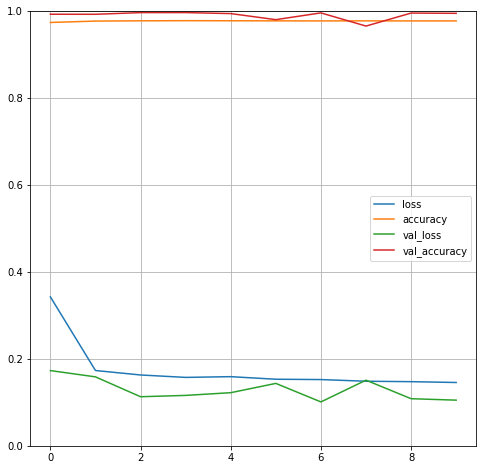

In [ ]:
pd.DataFrame(rnd_search_cv.best_estimator_.model.history.history).plot(figsize=(8,8))
plt.grid(True)
plt.gca().set_ylim(0,1)

In [ ]:
best_model = rnd_search_cv.best_estimator_.model
best_model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 35)               71        
 n)                                                              
                                                                 
 input_28 (InputLayer)       multiple                  0         
                                                                 
 dense_81 (Dense)            (None, 40)                1440      
                                                                 
 dense_82 (Dense)            (None, 40)                1640      
                                                                 
 dense_83 (Dense)            (None, 2)                 82        
                                                                 
Total params: 3,233
Trainable params: 3,162
Non-trainable params: 71
__________________________________________________

In [ ]:
score = best_model.evaluate(X_test, Y_test)

7630/7630 [==============================] - 18s 2ms/step - loss: 0.1049 - accuracy: 0.9947


Summary of the perfomace of the Sequential Model

As we can see the Model showed us a good result with a loss of 0.10 and an accuracy of 99.4 % with only 40 neurons per 1 layer (totally hidden 2 layers)

# Creating Decision Forest with TensorFlow






In [ ]:
!pip install tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.0 MB 18.2 MB/s 
     |████████████████████████████████| 578.0 MB 15 kB/s 
     |████████████████████████████████| 438 kB 71.5 MB/s 
     |████████████████████████████████| 5.9 MB 67.2 MB/s 
     |████████████████████████████████| 1.7 MB 54.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1

In [ ]:
import tensorflow_decision_forests as tfdf

In [ ]:
##add here train and test from prev slide
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_pd, label="default_ind")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_pd, label="default_ind")

/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core_inference.py:873: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


In [ ]:
# Creates and trains model
n_trees = 100
model = tfdf.keras.RandomForestModel(num_trees = n_trees)
model.fit(train_ds)

Use /tmp/tmpthowki4c as temporary training directory
Reading training dataset...
Training dataset read in 0:00:23.837364. Found 966923 examples.
Training model...
Model trained in 0:03:35.830464
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [ ]:
# Summary of model structure

model.summary()

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (35):
	acc_now_delinq
	annual_inc
	collection_recovery_fee
	collections_12_mths_ex_med
	delinq_2yrs
	dti
	emp_length
	funded_amnt
	funded_amnt_inv
	inq_last_6mths
	installment
	int_rate
	last_pymnt_amnt
	loan_amnt
	mths_since_last_delinq
	mths_since_last_major_derog
	mths_since_last_record
	open_acc
	out_prncp
	out_prncp_inv
	policy_code
	pub_rec
	recoveries
	revol_bal
	revol_util
	term
	tot_coll_amt
	tot_cur_bal
	total_acc
	total_pymnt
	total_pymnt_inv
	total_rec_int
	total_rec_late_fee
	total_rec_prncp
	total_rev_hi_lim

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                 "policy_code" 12.547905 ##########

In [ ]:
# evaluates model

model.compile(metrics=["accuracy"])
print(model.evaluate(test_ds))

245/245 [==============================] - 7s 26ms/step - loss: 0.0000e+00 - accuracy: 0.9983
[0.0, 0.9983084797859192]


#Decision TREE Tensflow

In [ ]:
n_trees = 1
model = tfdf.keras.RandomForestModel(num_trees = n_trees)
model.fit(train_ds)

model.compile(metrics=["accuracy"])
print(model.evaluate(test_ds))

Use /tmp/tmpan124c_8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:19.724805. Found 966923 examples.
Training model...
Model trained in 0:00:05.483714
Compiling model...
Model compiled.
245/245 [==============================] - 5s 20ms/step - loss: 0.0000e+00 - accuracy: 0.9935
[0.0, 0.9934796690940857]


Conclusion Among all Tensflow Models
It can bee see that all models runned with good result
but the more evaluted model is Random Forest as it has lower Loss and Higher Accuracy
